In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "NF-YA"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn003161,MRQTKRKVNSRKGKQKQNRRQQFLLATENKAQIAQKRFAPEISLQD...,245,1
1,Achn029561,MPTKSKTEDQQAENGAHIIPPSAVYAQPWWRGIGNNAMSSPVGHIN...,317,1
2,Achn050401,MQDLCKKDSELSSTSTHSMTPRVTGGAPWLTSTALQIESTLSKSLS...,539,1
3,Achn059051,MTMHTVYLKEHDGIVQNPTSQLPPAAVPWWSGHGSQSAHTESFGQF...,699,1
4,Achn115261,MATPNQHDHNLKQMGFRFQDQDSSSTQSTGQSHHEVASIGESDPYG...,263,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1794,0.003344,0.000000,0.000000,0.010033,0.0,0.010033,0.000000,0.003344,0.006689,0.000000,...,0.000000,0.003344,0.000000,0.000000,0.000000,0.0,0.003344,0.000000,0.0,0.000000
3906,0.010309,0.000000,0.000000,0.000000,0.0,0.010309,0.000000,0.000000,0.010309,0.051546,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
453,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.006173,0.000000,0.012346,0.000000,...,0.000000,0.000000,0.006173,0.000000,0.000000,0.0,0.006173,0.000000,0.0,0.000000
1140,0.003846,0.003846,0.003846,0.007692,0.0,0.000000,0.003846,0.003846,0.011538,0.007692,...,0.003846,0.000000,0.003846,0.000000,0.000000,0.0,0.003846,0.000000,0.0,0.003846
4140,0.000000,0.000000,0.002967,0.000000,0.0,0.005935,0.000000,0.002967,0.002967,0.002967,...,0.002967,0.005935,0.002967,0.005935,0.002967,0.0,0.000000,0.002967,0.0,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3915, 441)
X_test: (979, 441)
y_train: (3915,)
y_test: (979,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 22s 470ms/step - accuracy: 0.4844 - loss: 0.6932

34/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6296 - loss: 0.6697   

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6836 - loss: 0.6332 - val_accuracy: 0.9847 - val_loss: 0.1009


Epoch 2/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.1281

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9905 - loss: 0.0632

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0621 - val_accuracy: 0.9872 - val_loss: 0.0436


Epoch 3/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0072

30/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0333

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0345 - val_accuracy: 0.9872 - val_loss: 0.0547


Epoch 4/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0055

32/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0272

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0279 - val_accuracy: 0.9885 - val_loss: 0.0473


Epoch 5/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0029

31/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0161

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0181 - val_accuracy: 0.9898 - val_loss: 0.0417


Epoch 6/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0037

31/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0159

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0198 - val_accuracy: 0.9885 - val_loss: 0.0559


Epoch 7/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.1000

31/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0307

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0264 - val_accuracy: 0.9898 - val_loss: 0.0502


Epoch 8/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0353

31/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0212

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0197 - val_accuracy: 0.9911 - val_loss: 0.0429


Epoch 9/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0018

32/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0129

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0131 - val_accuracy: 0.9911 - val_loss: 0.0430


Epoch 10/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0016

32/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0131

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0126 - val_accuracy: 0.9911 - val_loss: 0.0442


Epoch 11/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0015

31/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0085

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0096 - val_accuracy: 0.9911 - val_loss: 0.0455


Epoch 12/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0020

31/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0077

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0087 - val_accuracy: 0.9911 - val_loss: 0.0518


Epoch 13/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.2040e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0122    

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0118 - val_accuracy: 0.9898 - val_loss: 0.0420


Epoch 14/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0018

31/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0030

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0031 - val_accuracy: 0.9911 - val_loss: 0.0503


Epoch 15/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.6267e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0157    

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0144 - val_accuracy: 0.9911 - val_loss: 0.0478


Epoch 16/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0020

32/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0070

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0076 - val_accuracy: 0.9885 - val_loss: 0.0447


Epoch 17/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0017

32/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0087

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0085 - val_accuracy: 0.9911 - val_loss: 0.0456


Epoch 18/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.0348e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0053    

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0058 - val_accuracy: 0.9911 - val_loss: 0.0491



[Train Accuracy: 99.71% - Test Accuracy: 98.67%]


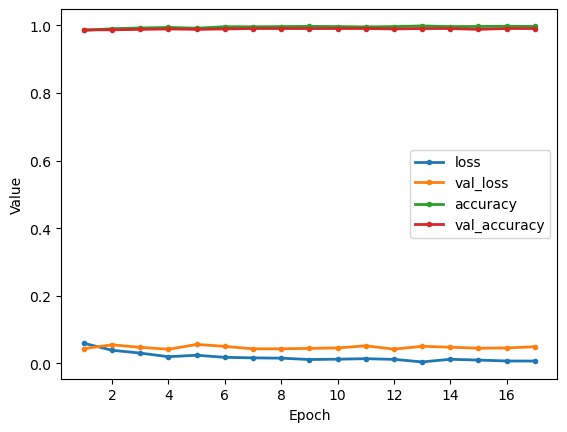

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3915, 8707)
X_test: (979, 8707)
y_train: (3915,)
y_test: (979,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,229,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,272,513 (8.67 MB)

 Trainable params: 2,272,513 (8.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 23s 482ms/step - accuracy: 0.5469 - loss: 0.6931

 9/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6018 - loss: 0.6921   

17/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6535 - loss: 0.6891

25/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7037 - loss: 0.6826

33/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7414 - loss: 0.6715

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7698 - loss: 0.6539

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7919 - loss: 0.6311

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7943 - loss: 0.6281 - val_accuracy: 0.9898 - val_loss: 0.0591


Epoch 2/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.0556

 9/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9832 - loss: 0.0719 

17/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9869 - loss: 0.0572

25/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9885 - loss: 0.0488

33/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9894 - loss: 0.0441

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9901 - loss: 0.0409

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9906 - loss: 0.0381 - val_accuracy: 0.9974 - val_loss: 0.0117


Epoch 3/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9688 - loss: 0.1114

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9895 - loss: 0.0400 

18/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9921 - loss: 0.0305

26/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9933 - loss: 0.0265

34/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9940 - loss: 0.0238

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9945 - loss: 0.0218

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9949 - loss: 0.0202 - val_accuracy: 0.9962 - val_loss: 0.0125


Epoch 4/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0014

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0100 

18/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0101

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0092

35/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0089

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0085

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0082 - val_accuracy: 0.9974 - val_loss: 0.0084


Epoch 5/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0011

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0018 

19/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0017

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.9974 - val_loss: 0.0127


Epoch 6/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.2542e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 9.2365e-04 

17/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0025    

26/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0030

34/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0032

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0031

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0031 - val_accuracy: 0.9962 - val_loss: 0.0115


Epoch 7/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.5799e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5782e-04 

19/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6011e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1892e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4367e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5382e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5510e-04 - val_accuracy: 0.9974 - val_loss: 0.0101


Epoch 8/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 8.9958e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5361e-04 

19/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3286e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0816e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7296e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4096e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3285e-04 - val_accuracy: 0.9974 - val_loss: 0.0094


Epoch 9/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.7469e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.3411e-04 

18/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2796e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0878e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9588e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8410e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7827e-04 - val_accuracy: 0.9962 - val_loss: 0.0105


Epoch 10/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 6.0444e-05

 9/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6042e-05 

17/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0116e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0094e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0072e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9450e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8479e-05 - val_accuracy: 0.9974 - val_loss: 0.0119


Epoch 11/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 8.9441e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2466e-04 

19/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8122e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9370e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9503e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9460e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9405e-04 - val_accuracy: 0.9962 - val_loss: 0.0111


Epoch 12/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.3142e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7393e-05 

18/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0103e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0458e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0446e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0414e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0343e-04 - val_accuracy: 0.9962 - val_loss: 0.0122



[Train Accuracy: 100.00% - Test Accuracy: 99.49%]


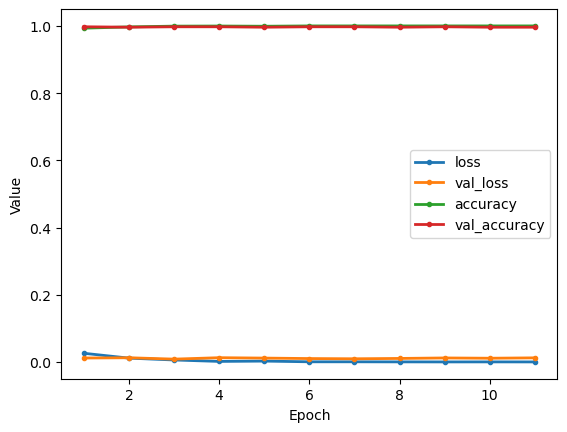

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      35,515,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,556,609 (135.64 MB)

 Trainable params: 35,556,609 (135.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 32s 670ms/step - accuracy: 0.4844 - loss: 0.6932

 2/49 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.5195 - loss: 0.6931 

 3/49 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.5252 - loss: 0.6931

 4/49 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.5286 - loss: 0.6930

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5254 - loss: 0.6930

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.5247 - loss: 0.6930

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5224 - loss: 0.6929

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5220 - loss: 0.6929

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5225 - loss: 0.6928

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5227 - loss: 0.6926

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5225 - loss: 0.6925

12/49 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.5219 - loss: 0.6924

13/49 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.5211 - loss: 0.6923

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.5207 - loss: 0.6922

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.5211 - loss: 0.6920

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.5225 - loss: 0.6918

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.5241 - loss: 0.6916

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.5262 - loss: 0.6913

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5279 - loss: 0.6910

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5300 - loss: 0.6908

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5326 - loss: 0.6905

22/49 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.5356 - loss: 0.6901

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5390 - loss: 0.6898

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5426 - loss: 0.6894

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5465 - loss: 0.6889

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.5506 - loss: 0.6885

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.5548 - loss: 0.6880

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.5589 - loss: 0.6875

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5630 - loss: 0.6869

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5671 - loss: 0.6863

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5713 - loss: 0.6856

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5755 - loss: 0.6849

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5796 - loss: 0.6842

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5837 - loss: 0.6834

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5878 - loss: 0.6825

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.5919 - loss: 0.6816

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.5959 - loss: 0.6806

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5998 - loss: 0.6795

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.6037 - loss: 0.6784

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6074 - loss: 0.6772

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6111 - loss: 0.6759

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6148 - loss: 0.6746

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6184 - loss: 0.6732

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6219 - loss: 0.6717

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6254 - loss: 0.6702

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6288 - loss: 0.6686

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6322 - loss: 0.6669

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6355 - loss: 0.6652

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6387 - loss: 0.6634

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.6418 - loss: 0.6617 - val_accuracy: 0.9860 - val_loss: 0.2268


Epoch 2/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9844 - loss: 0.2198

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9883 - loss: 0.2118

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9887 - loss: 0.2094

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9896 - loss: 0.2055

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9904 - loss: 0.2011

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9907 - loss: 0.1966

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9911 - loss: 0.1918

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9910 - loss: 0.1879

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9910 - loss: 0.1840

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9910 - loss: 0.1804

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9909 - loss: 0.1769

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9906 - loss: 0.1737

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9903 - loss: 0.1708

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9901 - loss: 0.1679

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9899 - loss: 0.1652

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9898 - loss: 0.1624

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9898 - loss: 0.1597

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9898 - loss: 0.1570

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9898 - loss: 0.1544

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9898 - loss: 0.1519

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9898 - loss: 0.1494

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9899 - loss: 0.1471

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9899 - loss: 0.1447

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9899 - loss: 0.1425

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9900 - loss: 0.1403

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9900 - loss: 0.1383

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9900 - loss: 0.1362

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9901 - loss: 0.1343

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9901 - loss: 0.1324

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9901 - loss: 0.1305

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9902 - loss: 0.1287

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9902 - loss: 0.1270

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9902 - loss: 0.1253

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9903 - loss: 0.1236

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9903 - loss: 0.1220

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9904 - loss: 0.1205

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9904 - loss: 0.1190

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9905 - loss: 0.1175

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9905 - loss: 0.1160

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9906 - loss: 0.1146

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9906 - loss: 0.1133

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9906 - loss: 0.1120

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9907 - loss: 0.1107

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9907 - loss: 0.1095

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9908 - loss: 0.1083

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9908 - loss: 0.1071

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9909 - loss: 0.1059

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9910 - loss: 0.1048

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9910 - loss: 0.1037

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9911 - loss: 0.1026 - val_accuracy: 0.9962 - val_loss: 0.0103


Epoch 3/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 0.0028

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 0.0025

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 0.0024

 4/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 0.0023

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 0.0026

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 0.0028

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 0.0031

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9998 - loss: 0.0039

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9996 - loss: 0.0045

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9993 - loss: 0.0052

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9991 - loss: 0.0057

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9990 - loss: 0.0061

13/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9989 - loss: 0.0064

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9988 - loss: 0.0066

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9987 - loss: 0.0067

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9987 - loss: 0.0068

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9987 - loss: 0.0070

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9986 - loss: 0.0071

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9986 - loss: 0.0072

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9986 - loss: 0.0072

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9986 - loss: 0.0073

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9986 - loss: 0.0073

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9986 - loss: 0.0073

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9986 - loss: 0.0073

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9986 - loss: 0.0073

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9986 - loss: 0.0073

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9986 - loss: 0.0073

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9986 - loss: 0.0073

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9987 - loss: 0.0073

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9987 - loss: 0.0072

31/49 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9987 - loss: 0.0072

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9987 - loss: 0.0072

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9987 - loss: 0.0071

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9987 - loss: 0.0071

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9987 - loss: 0.0071

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9987 - loss: 0.0070

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9987 - loss: 0.0070

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9988 - loss: 0.0069

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9988 - loss: 0.0069

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9988 - loss: 0.0069

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9988 - loss: 0.0069

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9988 - loss: 0.0069

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9988 - loss: 0.0068

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9988 - loss: 0.0068

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9988 - loss: 0.0068

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9988 - loss: 0.0068

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9988 - loss: 0.0067

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9988 - loss: 0.0067

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9988 - loss: 0.0067

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9988 - loss: 0.0067 - val_accuracy: 0.9962 - val_loss: 0.0063


Epoch 4/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 0.0013

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 0.0015

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 1.0000 - loss: 0.0016

 4/49 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 0.0016

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 1.0000 - loss: 0.0017

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 0.0017

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 0.0017

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 0.0017

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 0.0017

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 0.0017

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 0.0017

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 0.0017

13/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0017

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0017

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0017

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 0.0017

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0017

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0016

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0016

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0016

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0016

22/49 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0016

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0016

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9999 - loss: 0.0016

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9999 - loss: 0.0016

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9999 - loss: 0.0016

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9999 - loss: 0.0016

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9999 - loss: 0.0016

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9999 - loss: 0.0016

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9998 - loss: 0.0016

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9998 - loss: 0.0016

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9998 - loss: 0.0016

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9998 - loss: 0.0016

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9998 - loss: 0.0016

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9998 - loss: 0.0016

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9998 - loss: 0.0016

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9998 - loss: 0.0016

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9998 - loss: 0.0016

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9998 - loss: 0.0016

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9998 - loss: 0.0016

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9998 - loss: 0.0016

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9998 - loss: 0.0016

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9998 - loss: 0.0016

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9998 - loss: 0.0016

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9998 - loss: 0.0016

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9998 - loss: 0.0016

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9998 - loss: 0.0016

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9998 - loss: 0.0016

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9997 - loss: 0.0016

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9962 - val_loss: 0.0070


Epoch 5/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 0.0018

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 0.0015

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 0.0013

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 0.0012

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 0.0011

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 0.0010

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 9.6281e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 9.1721e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 8.7979e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 8.5022e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 8.2557e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 8.0312e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 7.8254e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 7.6359e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 7.4688e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 7.3114e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 7.1689e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 7.0396e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 6.9212e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 6.8119e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 6.7291e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 6.6595e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.6062e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.5550e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.5035e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.4523e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.4015e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.3503e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 6.3015e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 6.2549e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 6.2095e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 6.1662e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 6.1225e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 6.0793e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 6.0521e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 6.0245e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.9971e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.9706e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.9444e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.9189e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.8929e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.8672e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.8412e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.8166e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.7920e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.7681e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.7444e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.7205e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.6992e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 5.6788e-04 - val_accuracy: 0.9962 - val_loss: 0.0076


Epoch 6/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 4.7625e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 6.5785e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 6.6594e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 6.4831e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 6.2860e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 6.1057e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 5.9368e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 5.7729e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 5.6192e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 5.4774e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 5.3405e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 5.2398e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.1507e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.0641e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 4.9867e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 4.9177e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 4.8537e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 4.7931e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 4.7346e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 4.6810e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 4.6290e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 4.5781e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 4.5304e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 4.4849e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 4.4412e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 4.3996e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 4.3598e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 4.3220e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 4.2863e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 4.2518e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 4.2174e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.1845e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.1522e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.1214e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.0909e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.0622e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.0342e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 4.0076e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.9823e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.9573e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.9325e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.9094e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.8873e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.8654e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.8442e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.8234e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.8029e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.7833e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.7642e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 3.7459e-04 - val_accuracy: 0.9962 - val_loss: 0.0092


Epoch 7/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 1.0000 - loss: 1.8886e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 2.0432e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 2.0261e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 1.9451e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 1.8679e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 1.8228e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.8105e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 1.7990e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.7944e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.7923e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 1.7850e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 1.7784e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.7797e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.7877e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.7905e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.7915e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.7915e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.7899e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.7874e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.7859e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.7854e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.7877e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.7890e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7907e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7921e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7924e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7940e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7981e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.8023e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.8063e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.8096e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.8116e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.8129e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.8153e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.8173e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.8192e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.8208e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.8221e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.8230e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.8237e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.8241e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.8257e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.8290e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.8323e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.8353e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.8381e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.8404e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.8421e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.8435e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.8448e-04 - val_accuracy: 0.9962 - val_loss: 0.0095


Epoch 8/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 1.0000 - loss: 1.2038e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 1.0000 - loss: 1.2484e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 1.0000 - loss: 1.3913e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 1.4994e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 1.6102e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 2.3295e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 2.7512e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 3.0223e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 3.1929e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 3.2914e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 3.3470e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 3.3748e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 3.3845e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 3.3791e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 3.3642e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 3.3489e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 3.3341e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 3.3153e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 3.2950e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 3.2747e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 3.2531e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 3.2301e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 3.2065e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 3.1955e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 3.1885e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 3.1802e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 3.1709e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 3.1626e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 3.1527e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 3.1436e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 3.1334e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 3.1228e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 3.1160e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.1087e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.1006e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.0918e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.0844e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.0774e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.0699e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 3.0623e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.0542e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.0454e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.0364e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.0276e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.0185e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.0089e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.9994e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.9901e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.9805e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.9712e-04 - val_accuracy: 0.9962 - val_loss: 0.0084


Epoch 9/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 1.0000 - loss: 1.0225e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 1.4342e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 1.4844e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 1.4531e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 1.4288e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.4102e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.3845e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 1.3516e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 1.3438e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.3346e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.3209e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 1.3054e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 1.2901e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.2753e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.2614e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.2510e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.2400e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.2288e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.2212e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.2216e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.2204e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.2197e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.2178e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.2152e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.2123e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.2093e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.2060e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.2024e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.1988e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.1976e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.1958e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.1936e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.1907e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.1878e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.1849e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.1820e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.1789e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.1759e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.1736e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.1713e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.1690e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.1669e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.1648e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.1631e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.1613e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.1595e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.1577e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.1559e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.1541e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.1524e-04 - val_accuracy: 0.9962 - val_loss: 0.0087


Epoch 10/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 1.0000 - loss: 7.6872e-05

 2/49 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 1.0000 - loss: 8.1573e-05

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 8.2256e-05

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 8.3546e-05

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 8.5491e-05

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 8.6566e-05

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 8.7071e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.0242e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 1.1339e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.2074e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.2555e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 1.2878e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.3105e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.3267e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.3384e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.3497e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.3566e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.3600e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.3631e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.3655e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.3660e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.3649e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.3633e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.3605e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.3570e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.3529e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.3483e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.3439e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.3415e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.3383e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.3350e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.3319e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.3285e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.3249e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.3212e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.3174e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.3133e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.3099e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.3066e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.3032e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.2998e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.2962e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.2924e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.2886e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.2849e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.2811e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.2773e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.2734e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.2694e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 1.2656e-04 - val_accuracy: 0.9962 - val_loss: 0.0088


Epoch 11/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 4.1370e-05

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 3.9662e-05

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 1.0000 - loss: 4.4410e-05

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 4.7428e-05

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 4.8989e-05

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 4.9762e-05

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.0099e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 5.0417e-05

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 5.2578e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.4319e-05

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.5364e-05

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.6428e-05

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.7319e-05

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 6.0606e-05

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 6.3226e-05

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 6.5377e-05

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 6.7112e-05

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 6.8556e-05

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 6.9805e-05

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 7.0854e-05

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 7.1763e-05

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 7.2579e-05

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 7.3251e-05

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 7.3790e-05

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 7.4318e-05

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 7.4735e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 7.5057e-05

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 7.5301e-05

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 7.5509e-05

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 7.5698e-05

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 7.5842e-05

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.5987e-05

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.6070e-05

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.6118e-05

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.6213e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.6301e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.6360e-05

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.6385e-05

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.6389e-05

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.6380e-05

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.6356e-05

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.6331e-05

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.6327e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.6301e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.6258e-05

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.6244e-05

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.6211e-05

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.6190e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.6156e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 7.6124e-05 - val_accuracy: 0.9962 - val_loss: 0.0087


Epoch 12/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.8467e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 1.0000 - loss: 1.5539e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 1.3596e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 1.2380e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 1.1540e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 1.0957e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 1.0442e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 1.0014e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 9.6836e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 9.4136e-05

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 9.1552e-05

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 8.9139e-05

13/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 8.6991e-05

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 8.5279e-05

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 8.4003e-05

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 8.2748e-05

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 8.1585e-05

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 8.0445e-05

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 7.9663e-05

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 7.8974e-05

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 7.8290e-05

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 7.7717e-05

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 7.7316e-05

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 7.8556e-05

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 7.9618e-05

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 8.0486e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 8.1239e-05

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 8.1871e-05

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 8.2490e-05

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 8.2994e-05

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 8.3469e-05

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 8.3869e-05

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 8.4191e-05

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 8.4450e-05

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 8.4637e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 8.4796e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 8.4916e-05

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 8.5475e-05

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 8.5966e-05

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 8.6416e-05

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.6798e-05

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.7141e-05

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.7432e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 8.7696e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.7942e-05

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.8147e-05

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.8326e-05

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.8475e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.8611e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 8.8740e-05 - val_accuracy: 0.9962 - val_loss: 0.0065



[Train Accuracy: 100.00% - Test Accuracy: 99.59%]


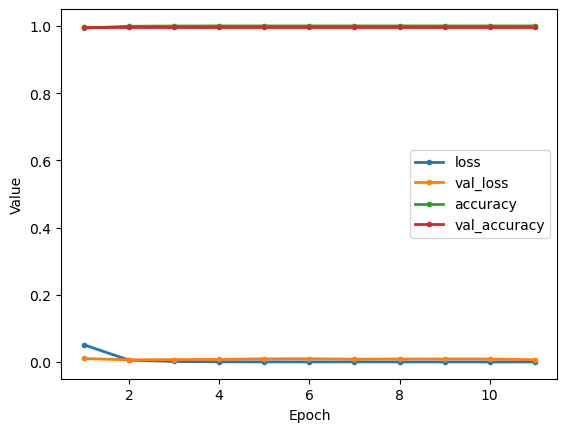

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

 7/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 7/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [25]:
report.save()

Report saved as Output/Reports/NF-YA/report_YL58W14I.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################